In [2]:
import os
import json
from itertools import islice, repeat
import pandas as pd
from upsetplot import UpSet, from_indicators
from matplotlib import pyplot as plt
import seaborn as sns

data_dir = os.path.normpath(os.path.join(os.path.abspath(''), '..', 'data'))
graphs_dir = os.path.normpath(os.path.join(os.path.abspath(''), '..', 'graphs'))

distinct_colors = [
    "#332626", "#7f4400", "#7f7700", "#608075", "#40bfff", "#0000f2", "#ff80a2", "#735656", "#ffaa00", "#eeff00", "#40ffbf", "#0061f2", "#73698c", "#7f0011", "#ff2200", "#fff2bf", "#41f200", "#40f2ff", "#000066", "#f780ff", "#ffa280", "#332900", "#008022", "#005266", "#000073"
]

default_figsize_x, default_figsize_y = plt.rcParams["figure.figsize"]

sns.reset_defaults()
sns.set_theme(context="paper", font="Latin Modern Sans", font_scale=1.1, palette="colorblind")
plt.ion()


In [79]:
data_type_renames = {
    'app_id': 'app ID',
    'os': 'OS version',
    'idfv': 'IDFV',
    'other_uuids': 'other UUIDs',
    'idfa': 'IDFA',
    'rooted': 'rooted?',
    'ram_usage': 'RAM usage',
    'is_charging': 'is charging?',
    'emulator': 'emulator?',
    'local_ips': 'local IPs',
    'hashed_idfa': 'hashed IDFA',
    'in_foreground': 'in foreground?',
    'bssid': 'BSSID'
}
data_type_renamer = lambda d: (data_type_renames[d] if d in data_type_renames else d.replace('_', ' '))

tracker_renames = {
    'adcolony': 'AdColony',
    'branchio': 'Branch.io',
    'doubleclick': 'DoubleClick',
    'ioam': 'ioam.de',
    'ironsource': 'ironSource',
    'mopub': 'MoPub',
    'ms_appcenter': 'App Center',
    'onesignal': 'OneSignal',
    'startio': 'Start.io',
    'unity': 'Unity3d',
}
tracker_renamer = lambda t: (tracker_renames[t] if t in tracker_renames else t.capitalize())

platform_renamer = lambda p: 'Android' if p == 'android' else 'iOS'


In [3]:
def json_obj_from_file_to_matplotlib(path, max_rows=None, reverse=True):
    with open(os.path.join(data_dir, path)) as f:
        data = json.load(f)
        slice = islice(data.items(), 0, max_rows)
        items = list(slice)[::-1] if reverse else slice
        return zip(*items)


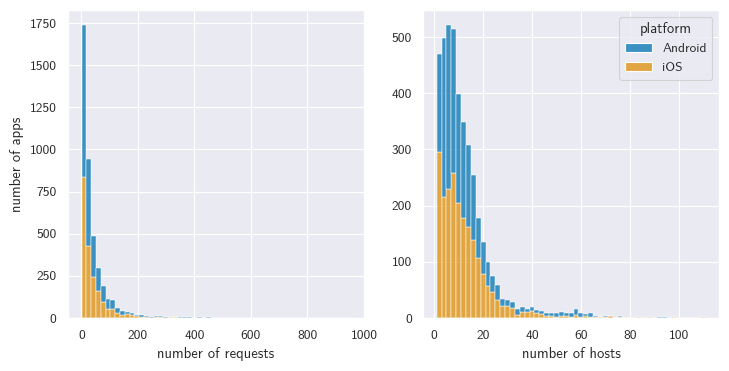

In [23]:
csv = pd.read_csv(os.path.join(data_dir, 'app_traffic.csv'), on_bad_lines='error', converters={
                  'platform': platform_renamer})


fig, axes = plt.subplots(1, 2, figsize=[1.4*default_figsize_x, default_figsize_y])
sns.histplot(data=csv.loc[(csv['request_count'] <= 1000)], x='request_count', ax=axes[0],
             binwidth=17, hue='platform', multiple='stack', legend=False)
axes[0].set_xlabel('number of requests')
axes[0].set_ylabel('number of apps')

sns.histplot(data=csv, x='host_count', ax=axes[1],
             binwidth=2, hue='platform', multiple='stack')
axes[1].set_xlabel('number of hosts')
axes[1].set_ylabel('')

fig.savefig(os.path.join(graphs_dir, 'requests_hosts_per_app.pdf'),
            bbox_inches="tight", pad_inches=0)


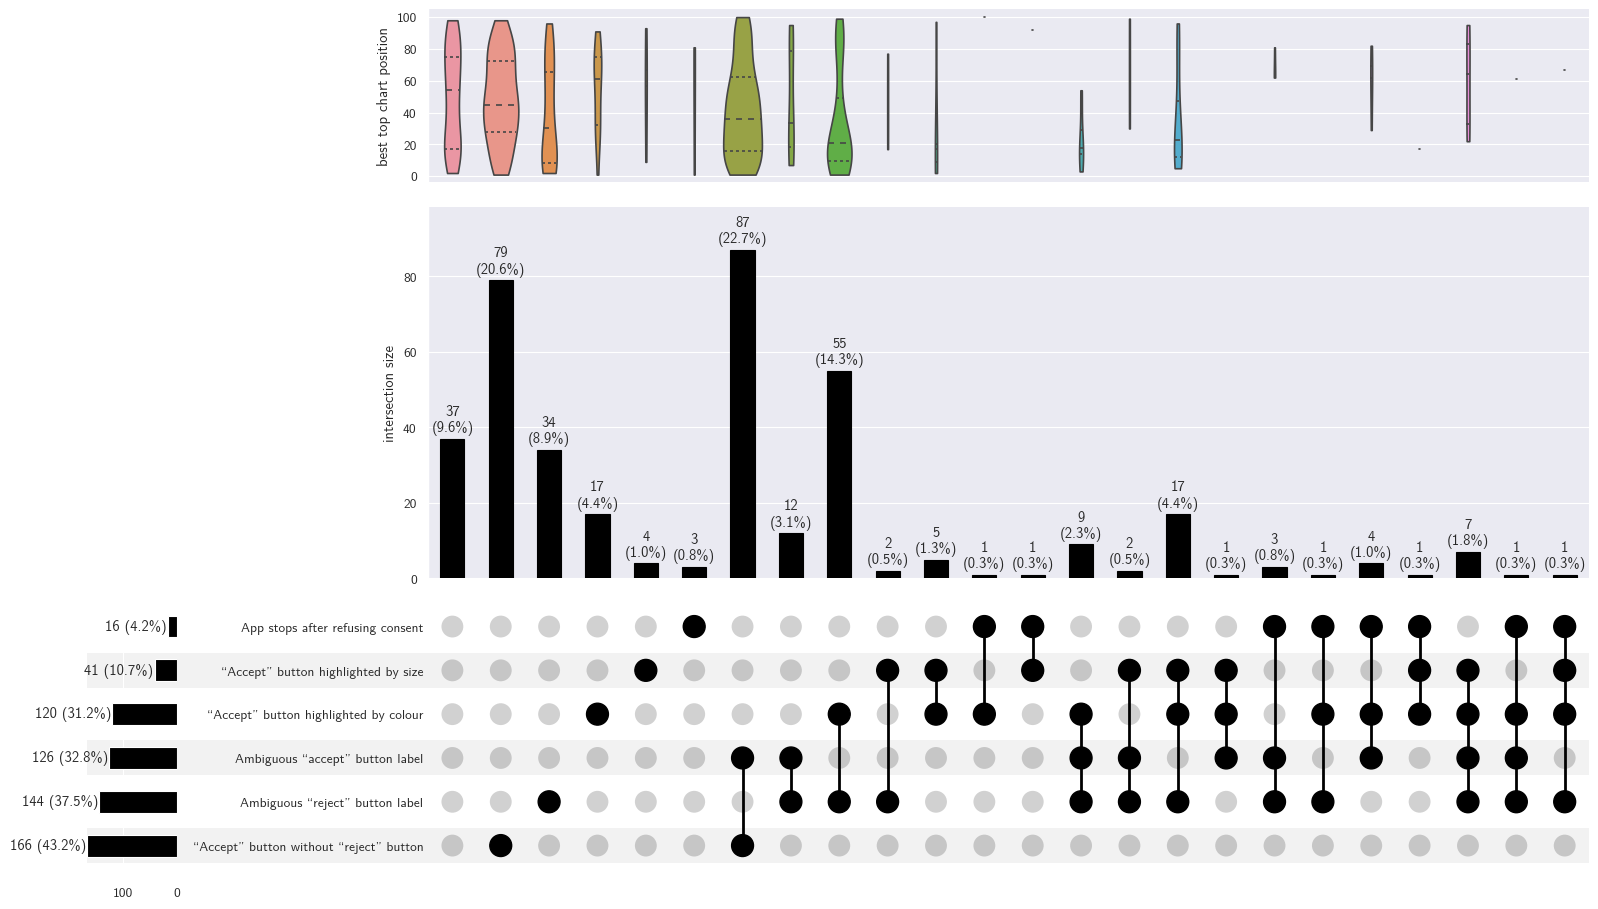

In [24]:
csv = pd.read_csv(os.path.join(data_dir, 'dialogs.csv'), on_bad_lines='error', header=0, names=[
                  'name', 'platform', 'version', 'categories', 'best_position', 'best_position_set', 'verdict', 'App stops after refusing consent', '“Accept” button highlighted by colour', 'Ambiguous “accept” button label', 'Ambiguous “reject” button label', '“Accept” button highlighted by size', '“Accept” button without “reject” button'], converters={'platform': platform_renamer})
dialogs = csv.loc[(csv['verdict'] == 'dialog') |
                  (csv['verdict'] == 'maybe_dialog')]
data = from_indicators(
    lambda data: data.select_dtypes(bool), data=dialogs)

upset = UpSet(data, show_counts=True, show_percentages=True,
              intersection_plot_elements=8, element_size=45)
# upset.add_stacked_bars(by='platform', colors=cm.Pastel1,
#                        elements=13, title='Count by platform')
# upset.add_stacked_bars(by='best_position_set', colors=distinct_colors, elements=13, title='Count by best top chart position')
# upset.add_stacked_bars(by='categories', colors=distinct_colors, elements=13, title='Count by category')
upset.add_catplot(value='best_position', kind='violin',
                  elements=4, cut=0, scale='count', inner='quartiles')
# upset.add_catplot(value='best_position', kind='swarm', elements=8)
elements = upset.plot()

elements['extra1'].set_ylabel('best top chart position')
elements['intersections'].set_ylabel('intersection size')
y_min, y_max = elements['intersections'].get_ylim()
elements['intersections'].set_ylim(y_min, y_max+7)

plt.savefig(os.path.join(graphs_dir, 'dialog_dark_patterns.pdf'),
            bbox_inches="tight", pad_inches=0)

# TODO: Fix elements['shading'] not extending all the way on the left.

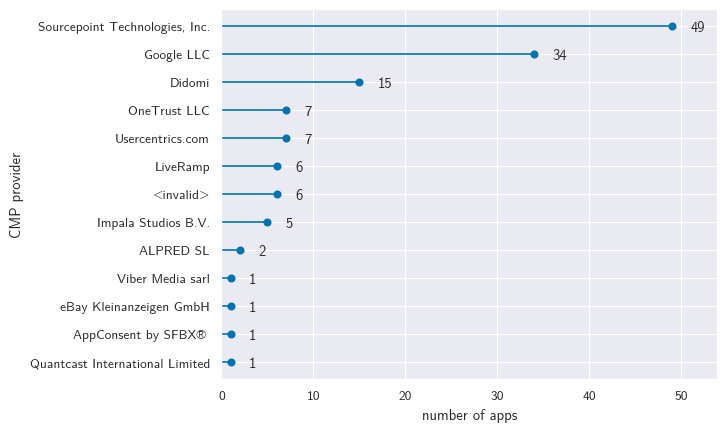

In [218]:
data = list(json_obj_from_file_to_matplotlib('tcf_cmps.json', None, True))

fig, ax = plt.subplots()
ax.set_ylabel('CMP provider')
ax.set_xlabel('number of apps')
ax.stem(*data, orientation='horizontal', basefmt='none')
_, x_max = ax.get_xlim()
ax.set_xlim(0, x_max + 2.5)

for i, v in enumerate(data[1]):
    ax.text(v + 2, i - 0.17, str(v))

fig.savefig(os.path.join(graphs_dir, 'tcf_cmps.pdf'), bbox_inches="tight", pad_inches=0)


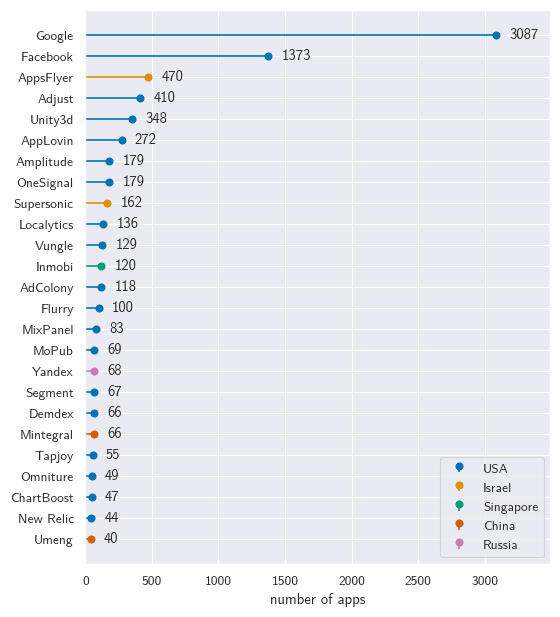

In [219]:
trackers, tracker_counts = json_obj_from_file_to_matplotlib(
    'exodus_tracker_counts.json', 25)

fig, ax = plt.subplots(figsize=[default_figsize_x, default_figsize_y * 1.8])
ax.set_xlabel('number of apps')

tracker_countries = {
    "Google": "USA",  # https://policies.google.com/privacy
    "Facebook": "USA",  # https://www.facebook.com/about/privacy
    "AppsFlyer": "Israel",  # https://www.appsflyer.com/legal/services-privacy-policy/
    "Adjust": "USA",  # https://www.adjust.com/terms/privacy-policy/
    "Unity3d": "USA",  # https://unity3d.com/legal/privacy-policy
    "AppLovin": "USA",  # https://www.applovin.com/privacy/
    "OneSignal": "USA",  # https://onesignal.com/privacy_policy
    "Supersonic": "Israel",  # https://supersonic.com/privacy/
    "Amplitude": "USA",  # https://amplitude.com/privacy
    "Localytics": "USA",  # https://uplandsoftware.com/localytics/app-privacy/
    "Vungle": "USA",  # https://vungle.com/privacy/
    "AdColony": "USA",  # https://www.adcolony.com/privacy-policy/
    "Inmobi": "Singapore",  # https://opencorporates.com/companies/sg/200811408G
    "Flurry": "USA",  # https://developer.yahoo.com/flurry/legal-privacy/terms-service/flurry-analytics-terms-service.html
    "MixPanel": "USA",  # https://mixpanel.com/legal/privacy-policy/
    "Mintegral": "China",  # https://www.mintegral.com/en/privacy/
    "Segment": "USA",  # https://segment.com/legal/privacy-04-2018/
    "Yandex": "Russia",  # https://yandex.com/legal/confidential/
    "MoPub": "USA",  # https://www.mopub.com/en/legal/privacy
    "Demdex": "USA",  # https://experienceleague.adobe.com/docs/audience-manager/user-guide/reference/demdex-calls.html
    "Tapjoy": "USA",  # https://www.tapjoy.com/legal/general/privacy-policy/
    "ChartBoost": "USA",  # https://answers.chartboost.com/en-us/articles/200780269
    "Omniture": "USA",  # https://en.wikipedia.org/wiki/Omniture
    "New Relic": "USA",  # https://newrelic.com/termsandconditions/privacy
    "Umeng": "China",  # https://reports.exodus-privacy.eu.org/en/trackers/119/
}
# This is apparently how you get an ordered set, see: https://stackoverflow.com/a/53657523
countries = list(dict.fromkeys(tracker_countries.values()))

for idx, country in enumerate(countries):
    trackers_in_country = filter(
        lambda tracker: tracker_countries[tracker] == country, trackers)
    indices = [trackers.index(tracker) for tracker in trackers_in_country]
    counts = [tracker_counts[i] for i in indices]
    ax.stem(indices, counts, orientation='horizontal', basefmt='none',
            linefmt=f'C{idx}-', markerfmt=f'C{idx}o', label=country)

ax.set_yticks(range(0, len(trackers)), trackers)

_, x_max = ax.get_xlim()
ax.set_xlim(0, x_max + 250)

ax.legend()

for i, v in enumerate(tracker_counts):
    ax.text(v + 100, i - 0.2, str(v))

fig.savefig(os.path.join(graphs_dir, 'exodus_tracker_counts.pdf'),
            bbox_inches="tight", pad_inches=0)


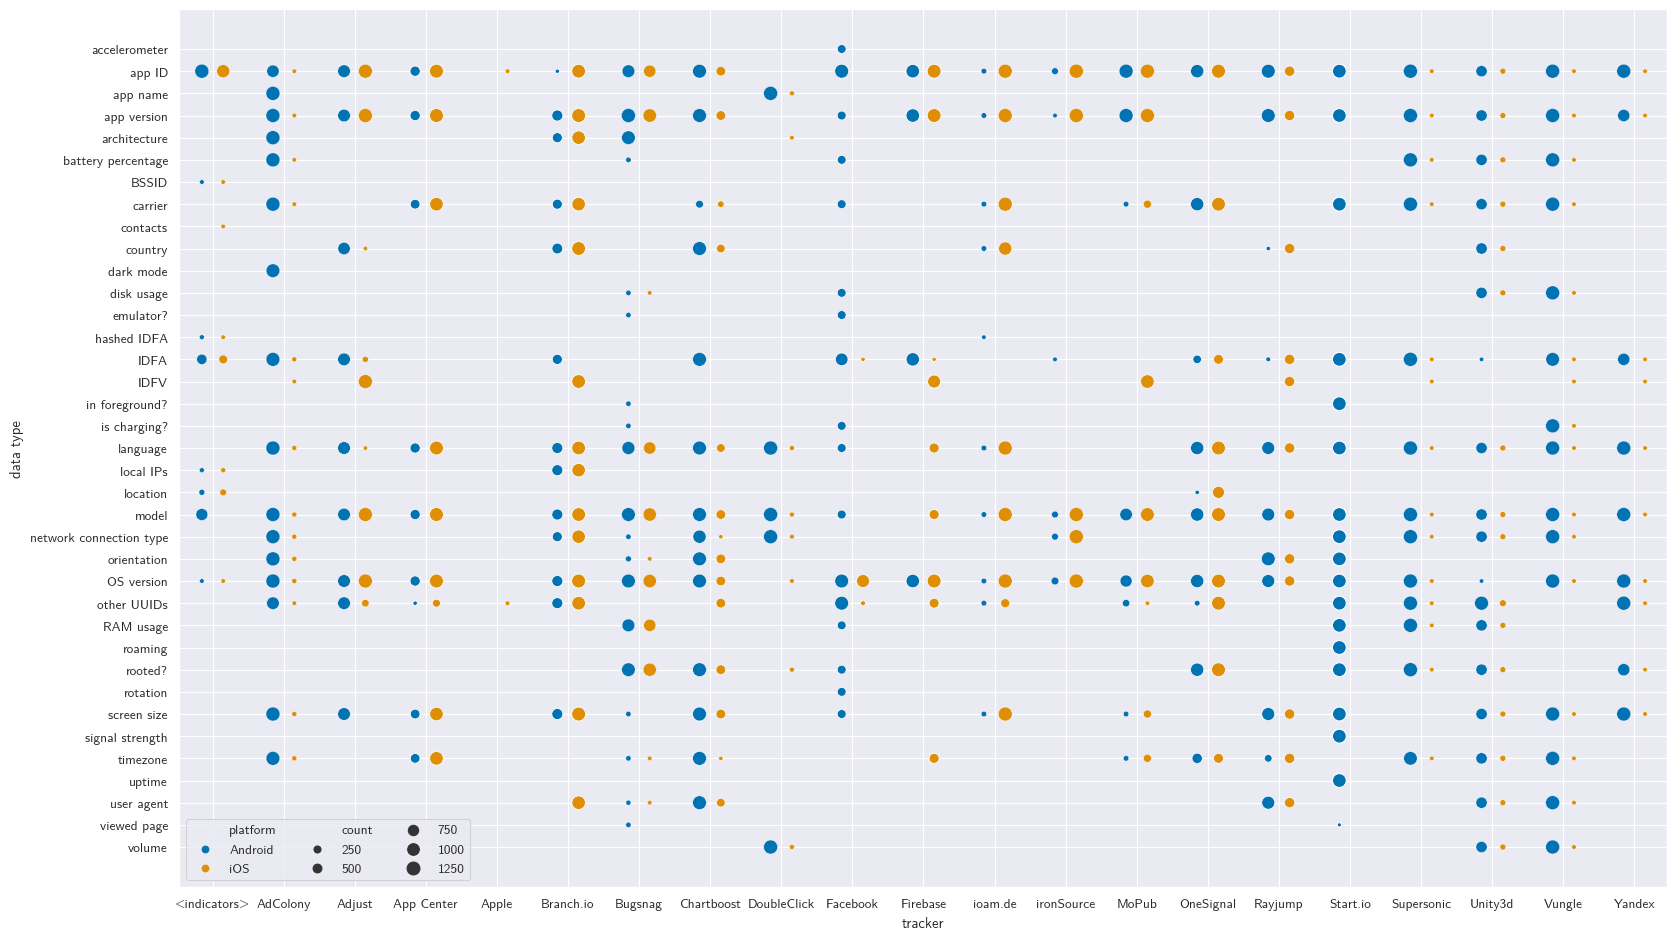

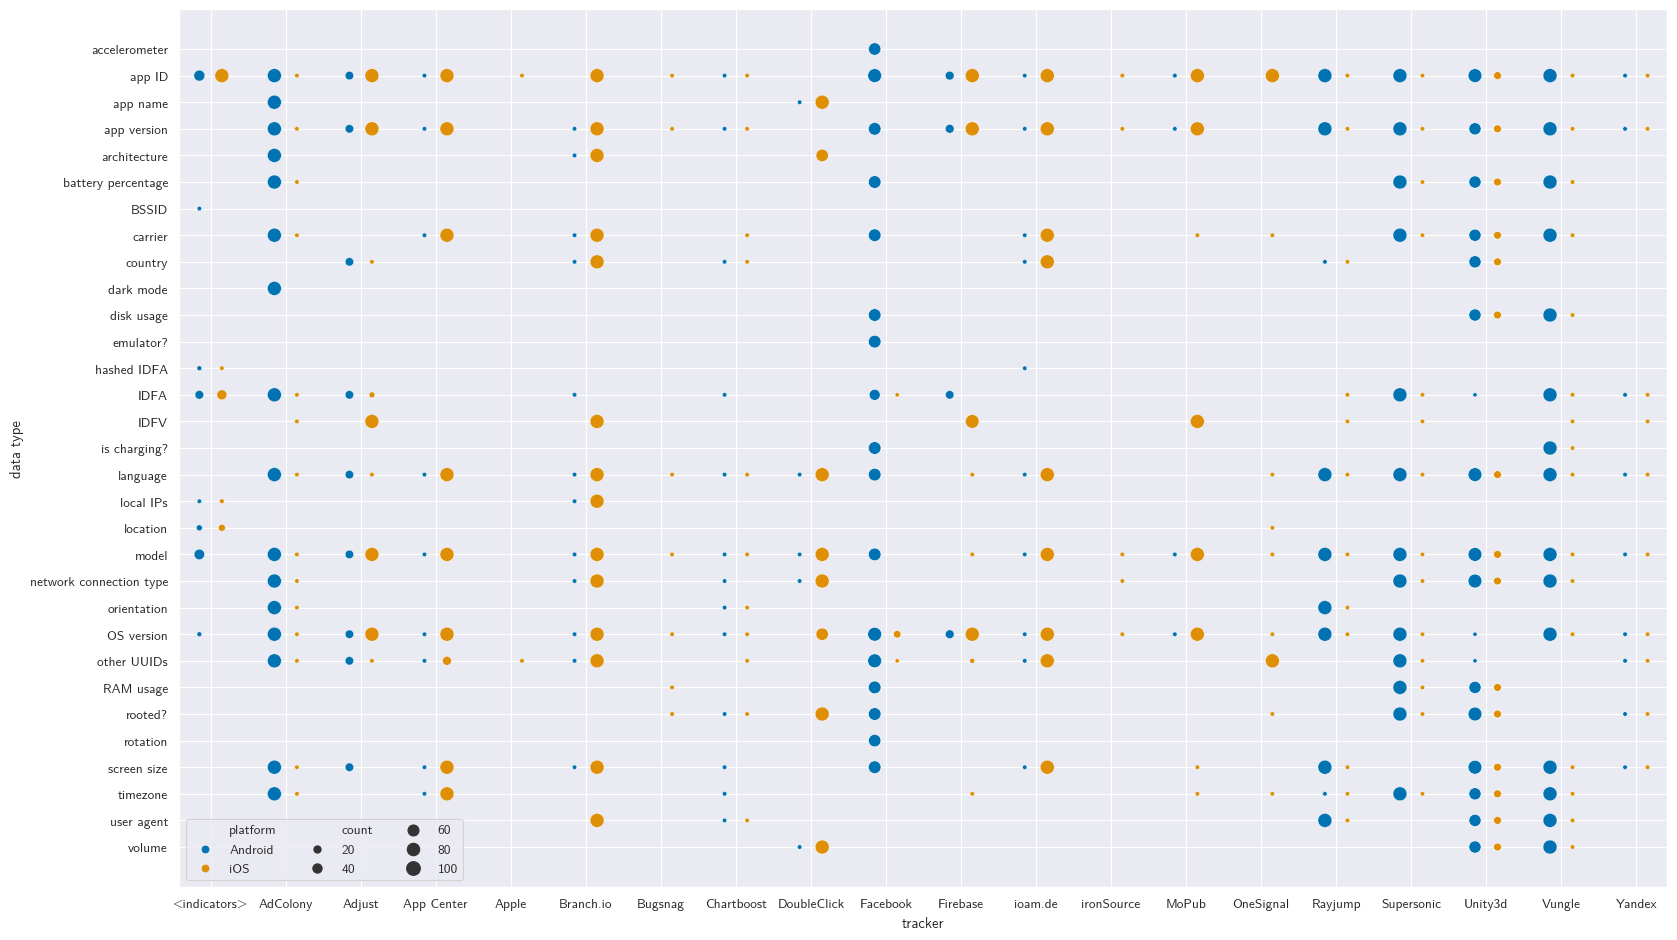

In [95]:
for type in ['initial', 'accepted']:
    csv = pd.read_csv(os.path.join(
        data_dir, f'apps_trackers_data_types_{type}_counts.csv'), on_bad_lines='error', converters={'data_type': data_type_renamer, 'platform': platform_renamer, 'tracker': tracker_renamer}).sort_values(by=['tracker'], key=lambda col: col.str.lower())
    ordered_data_types = sorted(csv['data_type'].unique(), key=str.lower)
    csv['data_type'] = pd.Categorical(csv['data_type'], categories=ordered_data_types, ordered=True)

    x_labels = csv['tracker'].unique()

    fig, ax = plt.subplots(figsize=[3.2*default_figsize_x, 2.85*default_figsize_y])

    for i, label in enumerate(x_labels):
        rows = csv.loc[csv['tracker'] == label]

        x = [i + (-0.15 if platform == 'Android' else 0.15)
            for platform in rows['platform']]
        sns.scatterplot(x=x, y="data_type", hue="platform", hue_order=['Android', 'iOS'],
                        size="count", sizes=(10, 100), data=rows, ax=ax, legend=i == 0)

    ax.set_xticks(range(0, len(x_labels)))
    ax.set_xticklabels(x_labels)

    ax.set_xlabel('tracker')
    ax.set_ylabel('data type')

    x_min, x_max = ax.get_xlim()
    ax.set_xlim(x_min+0.7, x_max-0.7)

    sns.move_legend(ax, loc='lower left', ncol=3)

    fig.savefig(os.path.join(graphs_dir, f'apps_trackers_data_types_{type}.pdf'),
                bbox_inches="tight", pad_inches=0)


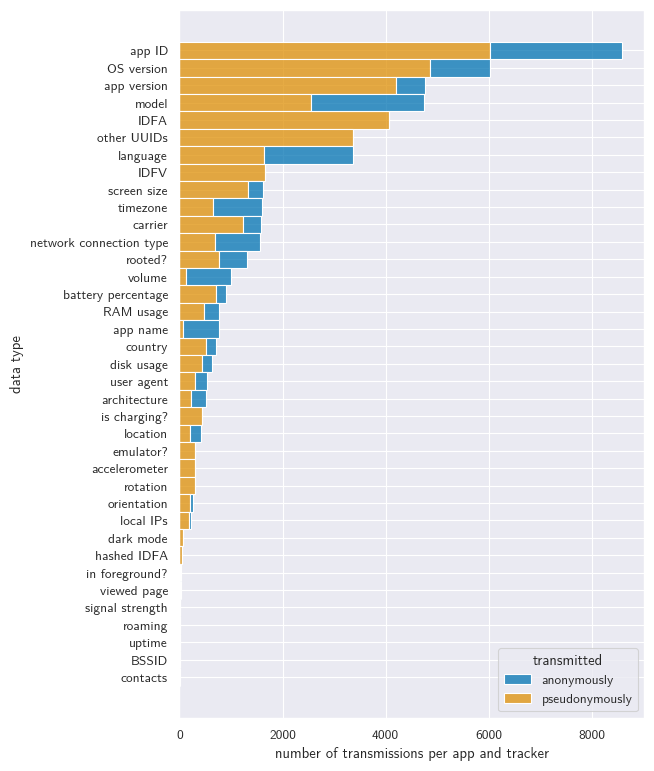

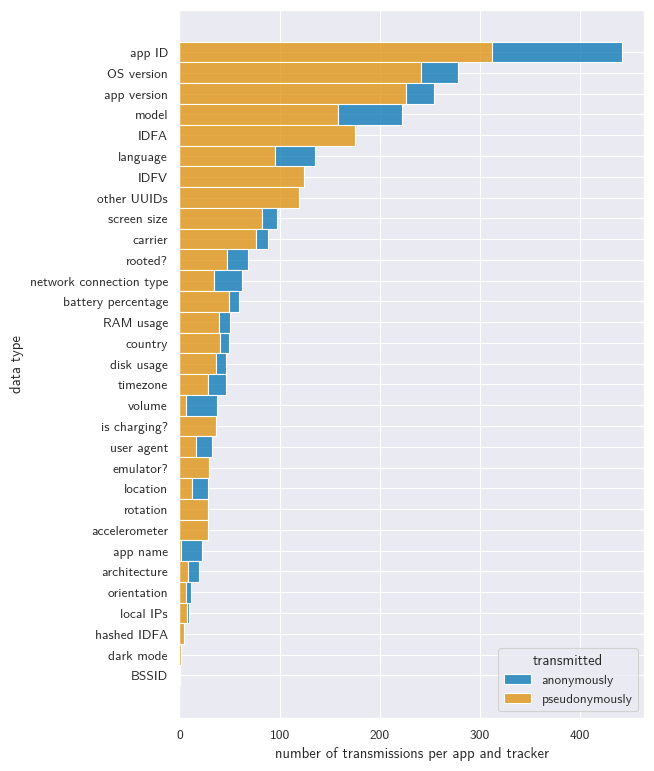

In [88]:
for type in ['initial', 'accepted']:
    csv = pd.read_csv(os.path.join(
        data_dir, f'apps_trackers_data_types_{type}.csv'), on_bad_lines='error', converters={'data_type': data_type_renamer}).sort_values(by=['data_type'])
    csv['data_type'] = pd.Categorical(
        csv['data_type'], categories=csv['data_type'].value_counts().keys(), ordered=True)

    fig, ax = plt.subplots(figsize=[default_figsize_x, 2.3*default_figsize_y])
    sns.histplot(y="data_type", hue="transmission_type", multiple="stack", hue_order=['anonymously', 'pseudonymously'], data=csv, ax=ax)
    ax.set_ylabel('data type')
    ax.set_xlabel('number of transmissions per app and tracker')
    sns.move_legend(ax, "lower right", title='transmitted')

    fig.savefig(os.path.join(graphs_dir, f'data_type_transmissions_{type}.pdf'),
                bbox_inches="tight", pad_inches=0)


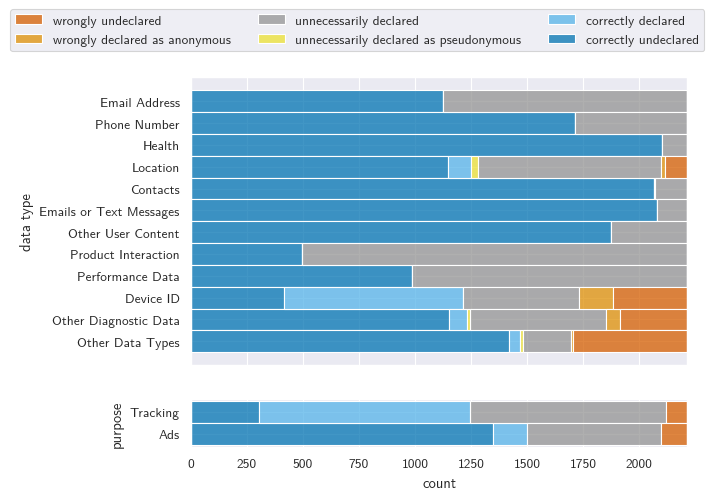

In [181]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [6, 1]})

declared_renamer = lambda d: d.replace('_', ' ')
purpose_renamer = lambda p: p.capitalize()

csv = pd.read_csv(os.path.join(
    data_dir, 'privacy_label_types.csv'), on_bad_lines='error', converters={'declared': declared_renamer})

hue_order = ['wrongly undeclared',
 'wrongly declared as anonymous',
 'unnecessarily declared',
 'unnecessarily declared as pseudonymous',
 'correctly declared',
 'correctly undeclared']
palette = [sns.color_palette()[i] for i in [3, 1, 7, 8, 9, 0]]

sns.histplot(y="data_type", hue="declared", hue_order=hue_order, palette=palette,
             multiple="stack", data=csv, ax=axes[0], legend=False)
axes[0].set_ylabel('data type')
axes[0].set_xlim(0, len(csv['app'].unique()))

csv = pd.read_csv(os.path.join(
    data_dir, 'privacy_label_purposes.csv'), on_bad_lines='error', converters={'declared': declared_renamer, 'purpose': purpose_renamer})
sns.histplot(y="purpose", hue="declared", hue_order=hue_order, palette=palette,
             multiple="stack", data=csv, ax=axes[1])
axes[1].set_xlabel('count')
sns.move_legend(axes[1], "lower center", bbox_to_anchor=(.335, 8.1), ncol=3, title=None)
fig.savefig(os.path.join(graphs_dir, 'privacy_labels.pdf'),
            bbox_inches="tight", pad_inches=0)


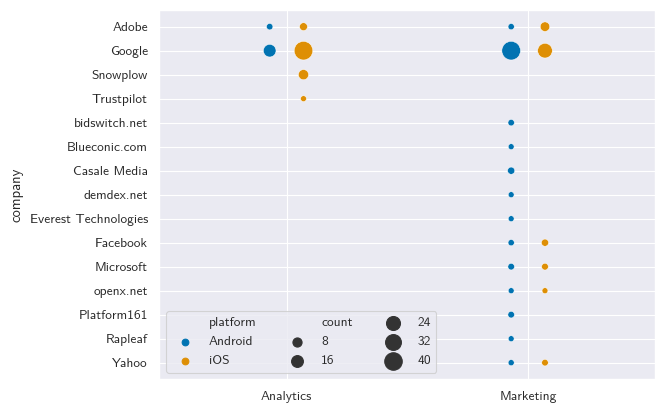

In [128]:
import numpy as np

csv = pd.read_csv(os.path.join(
    data_dir, 'cookie_counts.csv'), on_bad_lines='error', converters={'platform': platform_renamer}).sort_values(by=['company'], key=lambda col: col.str.lower())

fig, ax = plt.subplots()

for i, label in enumerate(x_labels):
    rows = csv.loc[csv['category'] == label]
    
    x = [i + (-0.07 if platform == 'Android' else 0.07) for platform in rows['platform']]
    sns.scatterplot(x=x, y="company", hue="platform", hue_order=['Android', 'iOS'],
                size="count", sizes=(18, 180), data=rows, ax=ax, legend=('brief' if i==0 else False))

ax.set_xticks(range(0, len(x_labels)))
ax.set_xticklabels(x_labels)

x_min, x_max = ax.get_xlim()
ax.set_xlim(x_min-0.4, x_max+0.4)

sns.move_legend(ax, "lower left", ncol=3)

fig.savefig(os.path.join(graphs_dir, 'cookies.pdf'),
            bbox_inches="tight", pad_inches=0)
